# Libraries and import data

In [1]:
# used libraries
import pandas as pd
import numpy as np
import networkx as nx # library for graphs/ networks
import matplotlib.pyplot as plt
import operator
from networkx.algorithms import community
from collections import defaultdict
from collections import Counter 
from networkx.drawing.nx_pylab import draw_networkx


In [3]:
# load in data
df_heroes = pd.read_csv('hero-network.csv')
df_edges = pd.read_csv('edges.csv')
df_nodes = pd.read_csv('nodes.csv')

Check the header and length of datasets to see if data is loaded in correctly

In [4]:
print('length df heroes', len(df_heroes))
print('length df edges', len(df_edges))
print('length df nodes', len(df_nodes))

length df heroes 574467
length df edges 96104
length df nodes 19090


In [5]:
df_heroes.head(5)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


In [6]:
df_edges.head(5)

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251


In [7]:
df_nodes.head(5)

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero


# 1. Data - data preparation
In this section, we will clean and prepare the data, so it can be used for the assignmnent. There are three inconsistencies that we will take into account:


*   Some heroes' names in 'hero-netowrk.csv' have extra spaces at the end of their names compared to their names in 'edges.csv'.
* Some heroes' names in 'hero-netowrk.csv' have an extra '/' at the end of their names compared to their names in 'edges.csv'.
* The hero name 'SPIDER-MAN/PETER PARKER' in 'edges.csv' has been changed to 'SPIDER-MAN/PETER PAR' in 'hero-network.csv' due to a string length limit in 'hero-network.csv'.

Furthermore, we will also remove the entries in her-network.csv that have the same hero in both columns.  In the graph, these entries form a self-loop. Because a self-loop makes no sense in this network, they will be removed. We will start with removing these 'duplicates'


In [8]:
# determine how many double heroes there are in the heroes dataframe
len(df_heroes[df_heroes.hero1 == df_heroes.hero2])

2232

In [9]:
# remove the rows of which the hero in the first column is the same as the second column
df_heroes.drop(df_heroes[df_heroes.hero1 == df_heroes.hero2].index, inplace=True)

In [10]:
# print the length of dataset to see if all the rows are deleted
print('length df heroes', len(df_heroes))

length df heroes 572235


For the edges and nodes files, we will check for duplicates, since we do not need them. The graphs that will be made with these files will be unweighted, so we do not need duplicates to determine a certain weight. For the heroes dataframe, we will apply a certain weight for the edges, so, therefore, we do have to keep duplicates.

In [11]:
print('Duplicate dataframe edges:', df_edges.duplicated().sum())
print('Duplicate dataframe nodes:', df_nodes.duplicated().sum())

Duplicate dataframe edges: 0
Duplicate dataframe nodes: 0


As we can see, there are no duplicates, so we do not need to remove them.

The rows with the same hero are removed from the heroes file. Now we will clean the way names of the heroes are saved in the separate files. 

Since some heroes have a 'regular' name and a superhero name, separated with a slash, we will only keep the superhero name for consistency. This will remove the problem of the extra slash, and will also remove the problem of names being to long for the heroes file.

In [12]:
# split the string on the slash and only keep the first ([0]) part of the string
df_heroes['hero1'] = [x.split('/')[0] for x in df_heroes['hero1']]
df_heroes['hero2'] = [x.split('/')[0] for x in df_heroes['hero2']]
df_edges['hero'] = [x.split('/')[0] for x in df_edges['hero']]

In [13]:
# split the string on the slash and only keep the first ([0]) part of the string
# do this only if the node type is a hero, so the name of comic stays intact
df_nodes['node'][df_nodes['type'] == 'hero'] = [x.split('/')[0] for x in df_nodes['node'][df_nodes['type'] == 'hero']]

As last step of the cleaning process, we will remove all spaces at the end of the string, if they are present. This will ensure consistency between all the datasets.

In [14]:
# remove last character of string if last character is a space
df_heroes = df_heroes.apply(lambda x: x.str.strip())
df_edges = df_edges.apply(lambda x: x.str.strip())
df_nodes = df_nodes.apply(lambda x: x.str.strip())

## First graph
In this part, we have written a function to compute the first graph. This graph is weighted and undirected. For the weights, we apply the following metric:



In [27]:
# Function for first graph
from tqdm import tqdm
from collections import defaultdict
from collections import Counter
def first_graph(data_heros,data_edges):
    Graph1 = nx.Graph()
    unique_heros = set.union(set(data_heros.hero1.unique()), set(data_heros.hero2.unique()))
    count_collaborations = {}

    for i in tqdm(unique_heros):
        a = len(data_heros[data_heros.hero1 == i].index)
        if a == 0:
            a = len(data_heros[data_heros.hero2 == i].index)
        count_collaborations[i] = a
    print(count_collaborations)
    for index, row in tqdm(data_heros.iterrows()):
        Graph1.add_node(row['hero1'])
        Graph1.add_node(row['hero2'])
        comics_with_hero1 = set(data_edges[data_edges['hero'] == row['hero1']].comic)
        comics_with_hero2 = set(data_edges[data_edges['hero'] == row['hero2']].comic)
        collaboration_in_different_comics = set.intersection(comics_with_hero1, comics_with_hero2)
        for i in collaboration_in_different_comics:
            ##math formula that computes weights
            #add an edge with weights
            weight = 1/count_collaborations[row['hero2']]
            Graph1.add_edge(row['hero1'], row['hero2'], weight=weight)
    return Graph1


In [28]:
Graph1 = first_graph(df_heroes, df_edges)

100%|██████████| 6413/6413 [03:41<00:00, 28.98it/s]


{'DYNA-MITE': 132, 'THOMAS, ROY': 51, 'KALMARI': 2, 'STONE II': 8, 'FIELSTEIN, FIREWORKS': 126, 'DILLON, JONATHAN': 15, 'LAMENT': 1, 'FIREBUG': 62, 'CITIZEN V III': 363, 'RANDEAU, DR.': 11, 'IKARYS': 2, 'DORNOVA-BLONSKY, NAD': 22, 'APE-X': 56, 'PUPPY': 62, 'NZAGA': 4, 'SHAW, OBADIAH': 5, 'DOCTOR DREDD': 10, 'DRAX DOPPELGANGER': 53, 'UNICORN II': 3, 'GLENN, HEATHER': 138, 'ZEMO': 85, 'LANDSCAPE': 1, 'KLEIN, SHIRLEY': 19, 'LEOPOLD, ARCHER': 3, 'REPLICUS': 25, 'BLITZKRIEG': 131, 'WEASON, SENATOR': 6, 'LORVEX': 7, 'APOLLO [GREEK GOD]': 68, 'MARGOYLE': 50, 'FIELDSTONE': 22, 'MCKENZIE, LEONARD': 17, 'WILLIS': 4, 'VIRAGO': 13, 'SILENCER': 3, 'POITIER, CLAUDE': 23, 'SIGMAR': 13, 'LOCOMOTIVE BREATH': 11, 'GARDENER': 70, 'BLAKE, DR. DONALD': 19, 'LOKI [ASGARDIAN]': 1226, 'JESTER': 37, 'VALKYRIE II | MUTANT': 15, 'ATOM SMASHER II': 9, 'MOONDANCER': 22, 'AIREO': 136, 'SIBERCAT': 16, 'SLASHER': 9, 'HELLSTORM': 434, 'DOLLAR BILL': 88, 'LOHAN, PETER': 21, 'SHE-HULK': 2797, 'TURMOIL': 5, 'LE FEY, MORG

572235it [2:04:34, 76.55it/s]


## Second graph
In this part, we have written a function to compute the second graph that is based on the given nodes and edges. This network is unweighted and undirected.

In [15]:
# Function for second graph
def second_graph(nodes, edges):
  # create graph
  Graph2 = nx.Graph()

  # add nodes and edges
  for index, row in edges.iterrows():
    Graph2.add_node(row['hero'], label='hero')
    Graph2.add_node(row['comic'], label='comic')
    Graph2.add_edge(row['hero'], row['comic'])
  return Graph2

In [17]:
# test the second graph
Graphtest = second_graph(df_nodes, df_edges)


The number of edges match the length of the dataset, as the info above shows. This makes sense, since every row indicates an edge.

# 2. Backend implementation

## Functionality 1

The function find_top_N is used to find the top N heroes who have appeared in the most number of comics

In [18]:
def find_top_N(N):
  n_appearances_in_comics = Counter(list(df_edges.hero))
  n_appearances_in_comics = sorted(n_appearances_in_comics.items(),key=lambda t:t[1], reverse=True)
  return [n_appearances_in_comics[i][0] for i in range(N)]

In [ ]:
def functionality_1(Graph, graph_type, N):
    topN = find_top_N(N)
    if graph_type == 1:
        Graph = Graph.subgraph(topN)
        n_nodes = len(Graph.nodes())
    #write for graph type ==2
    
        #type1
        #number_of_collaborations of each superhero with others
        #calculate naighbors of each node
        n_collaborations = defaultdict(int)
        for i in Graph.nodes():
            n_collaborations[i] = Graph.adj[i]
    
    #type2
    #number of heroes that have appeared in each comic
    if graph_type == 2:
        Graph = Graph.edge_subgraph((Graph.edges(topN)))
        nodes_comics = set()
        n_heroes = {}
        n_c = 0
        n_h = 0
        for i in Graph.nodes(data=False):
            if Graph.nodes[i] == {'label':'comic'}: 
                nodes_comics.add(i)
                n_c+=1
            else:
                n_h +=1
        for i in nodes_comics:
            n_heroes[i] = len(Graph.adj[i])
    
    # networks density 
    density = nx.density(Graph)
    
    #degree distribution
    degrees = {n:Graph.degree(n) for n in Graph.nodes()}
    
    #the average degree of the network
    ave_degree = sum(degrees.values())/Graph.number_of_nodes()
    
    # degree_dist
    degrees_dist = [Graph.degree(n) for n in Graph.nodes()]
    
    #the network hubs
    hubs = []
    temp = degrees.items()
    sorted_nodes = sorted(temp, key=lambda t: t[1], reverse=True)
    
    #how many items are in top 5 percent
    n = Graph.number_of_nodes()
    k = (n*5)//100
    hubs = [sorted_nodes[i][0] for i in range(k)]
    
    #is sparse or dense???
    
    n = Graph.number_of_nodes()
    #calculate maximum number of edges and minimum number of edges
    max_edge = n*(n-1)/2
    min_edge = n-1
    
    n_graph_edges = Graph.number_of_edges()
    if max_edge - n_graph_edges < n_graph_edges - min_edge:
        sparse_dense = "DENSE"
    else:
        
        sparse_dense = "SPARSE"
    if graph_type == 1:
        return n_nodes, n_collaborations, density, degrees_dist, ave_degree, hubs, sparse_dense
    else:
        return {'comic':n_c, 'hero':n_h}, n_heroes, density, degrees_dist, ave_degree, hubs, sparse_dense

node_info, n_heroes_in_comics, density, degrees_dist, average_degree, hubs, sparse_dense = functionality_1(Graphtest, 2, 10)

## Functionality 2

**Betweenness centrality** measures the number of times a node lies on the shortest path between other nodes.  
**The PageRank algorithm** measures the importance of each node within the graph, based on the number incoming relationships and the importance of the corresponding source nodes.  
**Closeness centrality** is a measure of the average shortest distance from each vertex to each other vertex. Specifically, it is the inverse of the average shortest distance between the vertex and all other vertices in the network.  
**The degree centrality** of a node in a graph is simply a count of the number of edges that connect to it.

In [ ]:
def functionality_2(Graph, graph_type,node,metrics,N):
    topN = find_top_N(N)
    if graph_type == 1:
      Graph = Graph.subgraph(topN)
    if graph_type == 2:
      Graph = Graph.edge_subgraph((Graph.edges(topN)))
    #betweenness centrality
    if metrics == 'betweenness centrality':
        betweenness = nx.betweenness_centrality(Graph)
        #top_n = sorted(betweenness.items(), key = lambda t: t[1], reverse=True)
        return betweenness, betweenness[node]
    #pagerank
    if metrics == 'pagerank':
        pagerank = nx.pagerank(Graph)
        #top_n = sorted(pagerank.items(), key = lambda t: t[1], reverse=True)
        return pagerank, pagerank[node]
    #closeness_centrality
    if metrics == 'closeness_centrality':
        closeness_centrality = nx.closeness_centrality(Graph)
        #top_n = sorted(closeness_centrality.items(), key = lambda t: t[1], reverse=True)
        return closeness_centrality,closeness_centrality[node]
    if metrics == 'degree_centrality':
        degree_centrality = nx.degree_centrality(Graph)
        #top_n = sorted(degree_centrality.items(), key = lambda t: t[1], reverse=True)
        return degree_centrality, degree_centrality[node]


## Functionality 3

In [22]:
def functionality_3(Graph,sequence_of_superheros, initial_node, end_node, N):
    
    topN = find_top_N(N)
    Graph = Graph.edge_subgraph((Graph.edges(topN)))
    path_dict = {}
    for i in sequence_of_superheros:
        if nx.has_path(Graph,initial_node, i)==True:
            path_dict[i] = list(nx.bidirectional_shortest_path(Graph, initial_node, i))      
    for i in path_dict:
        if nx.has_path(Graph, i, end_node)!= True:
            path_dict.pop(i)
        else:
            temp = list(nx.bidirectional_shortest_path(Graph, i, end_node))
            path_dict[i].extend(temp[1:])
    if len(path_dict) == 0:
        return "There is no such path"
    else:
        return sorted(path_dict.items(),key = lambda t: len(path_dict[t[0]]))[0][1] 

In [23]:
path_dict = functionality_3(Graphtest, ['THING', 'THOR', 'WOLVERINE'],'SPIDER-MAN','ICEMAN', 30)

## Functionality 4

In [ ]:
def functionality_4(Graph,graph_type,heroA, heroB, N):
    # make subgraph depending on top N
    topN = find_top_N(N)
    if graph_type == 1:
        Graph = Graph.subgraph(topN)
    elif graph_type == 2:
        Graph = Graph.edge_subgraph((Graph.edges(topN)))
    
    # calculate the number of edges that need to be removed to create two subgraphs
    cut_value, partition = nx.minimum_cut(Graph, heroA, heroB, capacity='weight')
    sub_graph1 = nx.subgraph(Graph, partition[0])
    sub_graph2 = nx.subgraph(Graph, partition[1])
    edges_between_subgraphs = [e for e in Graph.edges
        if (e[0] in sub_graph1 and e[1] in sub_graph2)
        or (e[0] in sub_graph2 and e[1] in sub_graph1)]
    return len(edges_between_subgraphs), Graph, sub_graph1, sub_graph2


## Functionality 5

In [29]:
def functionality_5(Graph,heroA, heroB, N):
    in_same_community = False
    topN = find_top_N(N)
    Graph = Graph.subgraph(topN)
    communities = community.louvain_communities(Graph, resolution = 1.1)
    subgraphs = []
    for i in communities:
        subgraphs.append(nx.subgraph(Graph, i))
        if heroA in i and heroB in i:
            in_same_community = True
    
    cnt_e = 0
    cnt_connecting_node = 0
    for e in Graph.edges:
        for sub_graph in subgraphs:
            if e not in sub_graph.edges:
                cnt_e+=1
        if cnt_e == len(subgraphs):
            cnt_connecting_node+=1
        cnt_e = 0
    return cnt_connecting_node, communities, in_same_community

In [30]:
cnt_connecting_node, communities, in_same_community = functionality_5(Graph1, 'CYCLOPS','IRON MAN',20)
print(cnt_connecting_node, communities, in_same_community, sep='\n')

152
[{'WATSON-PARKER, MARY', 'CYCLOPS', 'SPIDER-MAN', 'SCARLET WITCH', 'IRON MAN'}, {'WOLVERINE', 'HAWK', 'HULK', 'THOR', 'DR. STRANGE'}, {'DAREDEVIL', 'THING', 'BEAST', 'CAPTAIN AMERICA', 'INVISIBLE WOMAN', 'WASP'}, {'HUMAN TORCH', 'JAMESON, J. JONAH', 'MR. FANTASTIC'}, {'VISION'}]
True


# 3. Frontend Implementation

## Visualization 1 - Visualize some features of the network

In [ ]:
def visualisation_1(graph_data, graph_type, N):
    nr_nodes, var2, density, degrees, avg_degree, hubs, sparse_dense = functionality_1(graph_data, graph_type, N)
    
    # first table ( nr nodes, density, avg_degree, sparse or dense)
    table1_data = {'Number of nodes': [nr_nodes], 'Density' : density, 
             'Average degree' : avg_degree, 'Sparse or dense' : sparse_dense}
    table1 = pd.DataFrame(data=table1_data)
    display(table1)
    
    # second table for hubs
    table2_data = {'Hubs' : hubs}
    table2 = pd.DataFrame(data = table2_data)
    display(table2)
    
    # degree distribution
    plt.hist(degrees, bins=200)
    plt.xlabel('Degree')
    plt.title('Degree distribution')
    plt.show()
    
    # if graph = type 1, then depict number of collaborations of each hero in descending order 
    if graph_type == 1:
        d_descending = sorted(var2.items(), key=operator.itemgetter(1), reverse = True)
        d_descending = dict(d_descending[:20])
        plt.bar(range(len(d_descending)), list(d_descending.values()))
        plt.xticks(range(len(d_descending)), list(d_descending.keys()), rotation = 45)
        plt.title('Top 20 collaborations of the heroes')
        plt.show()
        
    # if graph = type 2, depict number of heroes who appeared in each comic
    # sorted in descending order 
    else:
        d_descending = sorted(var2.items(), key=operator.itemgetter(1), reverse = True)
        d_descending = dict(d_descending[:20])
        plt.bar(range(len(d_descending)), list(d_descending.values()))
        plt.xticks(range(len(d_descending)), list(d_descending.keys()), rotation = 45)
        plt.title('Top 20 comics with most heroes')
        plt.show()
        
    


Below, the visualization is shown for the type 2 graph. As can be seen, it visualizes two tables and two figures.
The first table shows the information containing the number of nodes in the graph, the density of the graph, the average degree and the sparsity. The second table shows the hubs of the graph. 

The first figure shows the distribution of the degree. As can be seen, there is a high spike around 10, which indicates that most nodes have 10 edges. The last figure the top 20 comics with the most appearing heroes. This graph can change depending on the number of heroes chosen as input.

,Number of nodes,Density,Average degree,Sparse or dense
0,"{'comic': 9236, 'hero': 50}",0.000643,5.968986,SPARSE


,Hubs
0,SPIDER-MAN
1,CAPTAIN AMERICA
2,IRON MAN
3,THING
4,THOR
...,...
459,A 128
460,X '97
461,A 95
462,M/CP 45/2


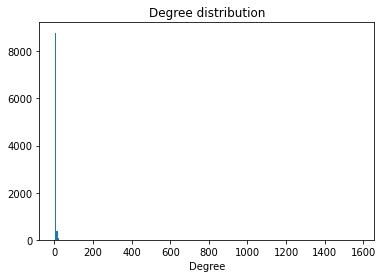

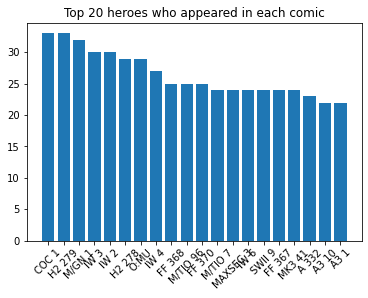

In [ ]:
# run the function for visualization
visualisation_1(Graphtest, 2, 50)

## Visualization 2 - Visualize centrality measure

In [ ]:
#A table containing the information related to the requested centrality measure for:
#The average of the requested centrality measure for all of the network's nodes
#The requested centrality measure's value for the given node

def visualisation_2(Graph, graph_type,node,metrics,N):
    metric, metric_node = functionality_2(Graph, graph_type,node,metrics,N)

    # create table for visualization
    table1_data = {'Chosen metric': [metrics], 'Average of measurement' : [sum(metric.values()) / len(metric)], 
             'Chosen node' : [node], 'Measurement of node' : [metric_node]}
    table1 = pd.DataFrame(data=table1_data)
    display(table1)



Below, functionality 2 is visualized with a table. For this visualization, the closeness centrality with graph type 2 and spider-man as specific node is used as example. The table shows the average of the chosen metric and also the value for the specific chosen node (in this case spider-man).

In [ ]:
visualisation_2(Graphtest,2,'SPIDER-MAN', 'closeness_centrality', 10)

,Chosen metric,Average of measurement,Chosen node,Measurement of node
0,closeness_centrality,0.2856,SPIDER-MAN,0.403571


## Visualisation 3

Path of comics
A 11
A '00


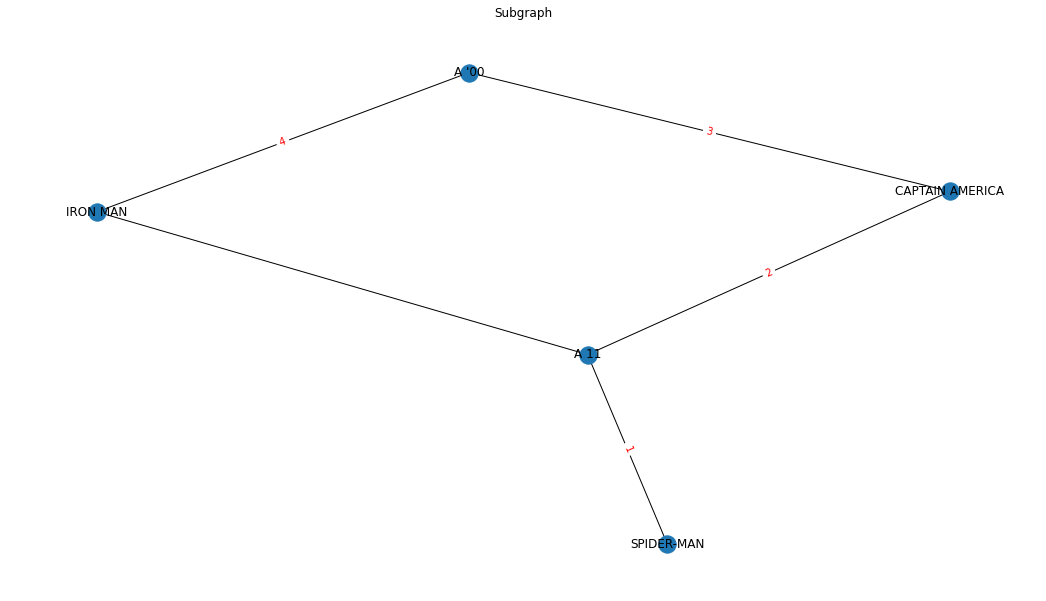

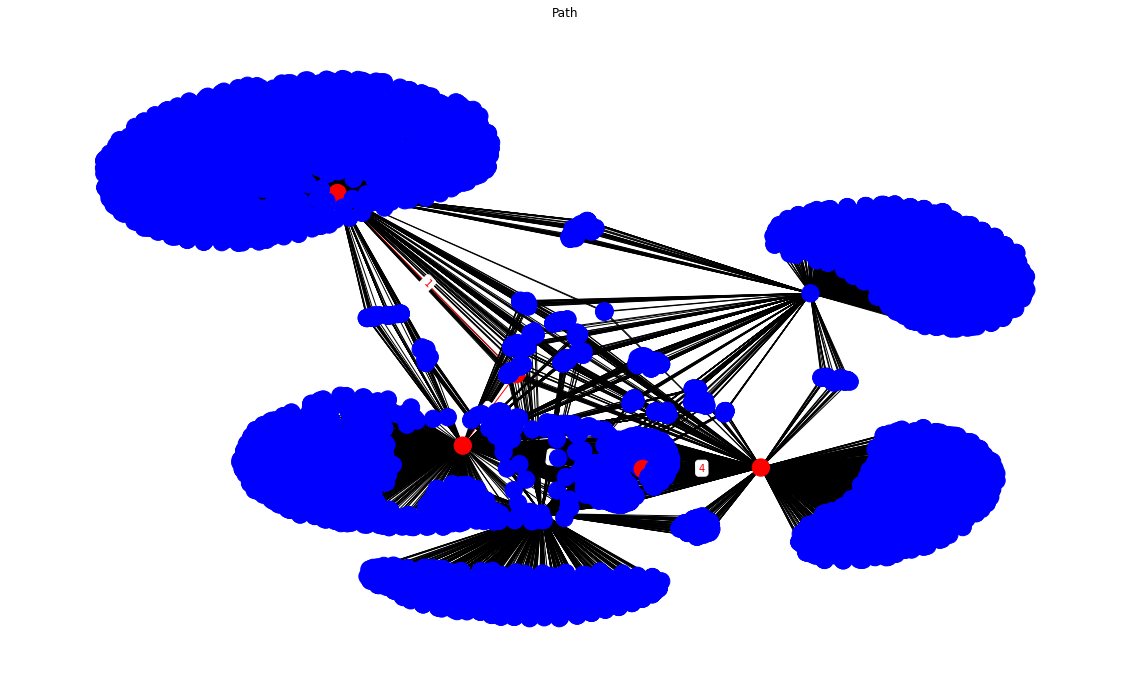

In [24]:
def visualisation_3(Graph,sequence_of_superheros, initial_node, end_node, N):
    a = functionality_3(Graph,sequence_of_superheros, initial_node, end_node, N)
    print("Path of comics")
    for i in range(len(a)):
        if i%2!=0:
            print(a[i])
    
    topN = find_top_N(5)
    
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.title("Subgraph")
    G_subgraph = Graph.subgraph(a)
    pos = nx.spring_layout(G_subgraph)
    nx.draw(G_subgraph,pos, with_labels = True)
    
    a_tuple = [(a[i], a[i+1]) for i in range(len(a)-1)]
    edges = {a_tuple[i]: i+1 for i in range(len(a_tuple))}
    
    
    nx.draw_networkx_edge_labels(
        G_subgraph,pos,
        edge_labels=edges,
        font_color='red'
    )
    plt.show()

    
    G = Graph.edge_subgraph((Graph.edges(topN)))    
    fig = plt.gcf()
    fig.set_size_inches(20, 12)
    plt.title("Path")
    color_map = []
    for node in G.nodes():
        if node in a:
            color_map.append('red')
        else: 
            color_map.append('blue')   
    color_map_edges = []
    for e in G.edges():
        if e in a_tuple:
            color_map_edges.append('red')
        else: 
            color_map_edges.append('black')
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=color_map,edge_color=color_map_edges, with_labels=False)
    nx.draw_networkx_edge_labels(
    G,pos,
    edge_labels=edges,
    font_color='red'
    )
    plt.show()

visualisation_3(Graphtest, ['CAPTAIN AMERICA'],'SPIDER-MAN', 'IRON MAN', 3)

## Visualisation 4 - Visualize the disconnected graph
For the visualisation of the fourth functionality, we have used Wolverine and Hulk as example. In the first figure, the complete original graph is shown. In the second figure the two subgraphs are shown with the node of Wolverine and Hulk is shown in blue while the other nodes are shown in green.
Although the subgraphs shows the two superheroes 'separated' we doubt if these subgraphs are correct, since one superhero is isolated, instead two subgraphs with multiple heroes.

In [ ]:
def visualisation_4(Graph, graph_type, hero1, hero2, N):
  nr_edges, graph, subgraph1, subgraph2 = functionality_4(Graph, graph_type, hero1, hero2, N)
  print('Number of edges that need to be removed:', nr_edges)
  
  # complete graph
  plt.title('Complete graph')
  draw_networkx(graph)
  plt.show()


  # subgraphs
  fig, axes = plt.subplots(nrows=1, ncols=2)
  ax = axes.flatten()
  fig.suptitle('Subgraphs with chosen nodes in blue')

  # first subgraph
  color_map = []
  for node in subgraph2:
    if node == hero1 or node == hero2:
      color_map.append('blue')
    else: 
      color_map.append('green')      
  nx.draw(subgraph2, ax=ax[0], node_color=color_map, with_labels=True)

  # second subgraph
  color_map_2 = []
  for node in subgraph1:
    if node == hero1 or node == hero2:
      color_map_2.append('blue')
    else: 
      color_map_2.append('green')  
  
    
  nx.draw(subgraph1, ax=ax[1], node_color=color_map_2, with_labels=True)
  plt.show()


Number of edges that need to be removed: 19


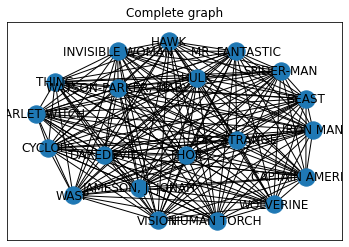

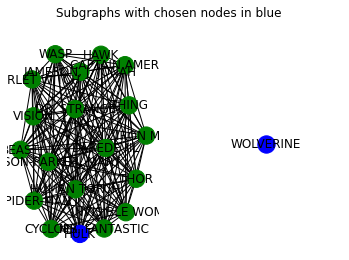

In [ ]:
visualisation_4(Graph1, 1, 'WOLVERINE', 'HULK', 20)

## Visualisation 5

Number of links that should be removed: 25
        Heros                                        Communities
0  SPIDER-MAN  {SPIDER-MAN, THING, CAPTAIN AMERICA, IRON MAN,...
1    IRON MAN  {SPIDER-MAN, THING, CAPTAIN AMERICA, IRON MAN,...


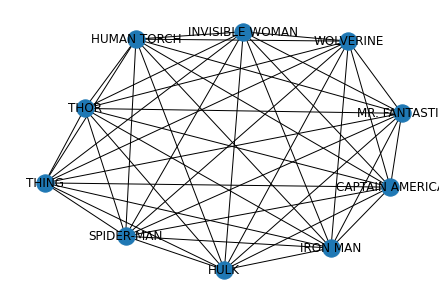

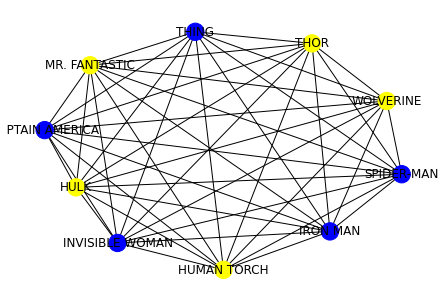

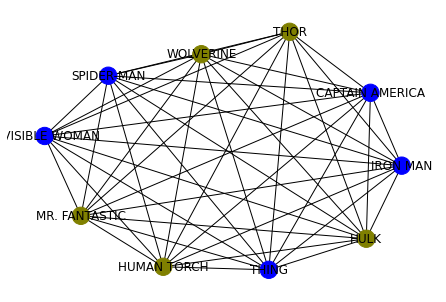

In [38]:
import pandas as pd
from collections import defaultdict
def visualisation_5(Graph,heroA, heroB, N):
    cnt_connecting_node, communities, in_same_community = functionality_5(Graph,heroA, heroB, N)
    print("Number of links that should be removed:", cnt_connecting_node)
    
    
    communities_heros = defaultdict(list)
    for i in communities:
        if heroA in i:
            communities_heros['Heros'].append(heroA)
            communities_heros['Communities'].append(i)
        if heroB in i:
            communities_heros['Heros'].append(heroB)
            communities_heros['Communities'].append(i)
            
    df_communities = pd.DataFrame(communities_heros)
    print(df_communities)
    
    
    #plotting original graph 
    plt.title = 'Original Graph'
    topN = find_top_N(N)
    Graph = Graph.subgraph(topN)
    nx.draw(Graph, with_labels = True)
    plt.show()
    
    #plotting graphs that shows the communities in the network
    plt.title = 'Show different communities'
    node_colors = ["yellow", "blue", "green", "purple", "orange", "red"]
    
    cnt = 0
    community_colors = {}
    for i in communities:
        community_colors[tuple(i)] = node_colors[cnt]
        cnt+=1
    
    color_map = []
    for i in Graph.nodes():
        for j in community_colors:
            if i in j:
                color_map.append(community_colors[tuple(j)])
    nx.draw(Graph, node_color=color_map, with_labels=True)
    plt.show()
    
    #Plot the final graph and identify the community/communities of Hero_1 and Hero_2
    plt.title = 'Identify communities of Hero1 and Hero2'
    
    communities_of_two_heros = []
    color_map_two_heroes = []
    if in_same_community == True:
        communities_of_two_heros.append(communities_heros['Communities'][0])
    else:
        communities_of_two_heros = communities_heros['Communities']
    for i in Graph.nodes():
        for j in communities_of_two_heros:
            if i in j:
                color_map_two_heroes.append(community_colors[tuple(j)])
            else:
                color_map_two_heroes.append('olive')
    
    
    nx.draw(Graph, node_color=color_map_two_heroes, with_labels=True)
    plt.show()

visualisation_5(Graph1, 'SPIDER-MAN','IRON MAN',10)
        

# 6. Algorithmic question
For this question, we have used classes to make it easier to run the recursive algorithm. In these classes and functions, we will use the following definitions:
* Grid: The search grid, in this case a 3 by 3 figure.
* Position: One of the points on the grid.

The code consists of 4 classes and 2 functions:

### Classes
* **PasscodeGrid**: This class consists of three functions. This class contains a matrix that indicates if a position on the grid is already visited or not. Furthermore, it can switch a position to visited/ not visited, and it makes a copy of the grid that can be used in the recursive algorithm to try different routes. 
* **PasscodeGridPosition:** This class holds the current position on the grid of the recursive algorithm and changes it. It also checks if the new position is on the grid and thus is a valid position. 
* **directiontonumeric:** This class will turn the given letters in the string to numeric values to make it possible to make calculations with them. Right and Down will be changed to a 1 and Left and Up to -1.
* **PasscodeGridDirectionCollection:** This class keeps track of the directions that still need to be taken. It also uses the directiontonumeric class to transform the letters to numerical values, and removes the next letter of the list and returns it as the next direction that has to be taken.

### Functions
* **calculatepossibilitiesfor:** This function contains the recursive aspect of the algorithm. It will keep running until there is no new position to visit and/ or the direction list is empty.
* **calculatepossibilities:** This function is called as first function and will 'start' the algorithm. It loops over the positions on the grid and takes them as a starting position for the recursive algorithm.

### Example
To give a better understanding of how the algorithm works, we will explain it using an example case. As input string we will use 'DRU' (so Down-Right-Up).

We will give this string to the calculatepossibilities function. This function will first check if the string is a valid string (which in this case is True). Next, it will loop over all the possible positions on the grid and for each position start the recursive part of the algorithm by calling the calculatepossibilitiesfor function.

In the calculatepossibilitiesfor function, the input string and the starting position determined by the loop in calculatepossibilities are used. We first make a copy of the grid and the directions (DRU) so we can use it again later on in the algorithm, and do not alter the original grid and given directions. Then we determine the next position based on the current position and the next direction on the direction_list. While this new position is valid (so it is on the grid), and this position is not visited yet, the algorithm will continue. If not, it will return the total number of possibilities. 
As long as the conditions of the while loop are met, the new position is set to visited, and the calculatepossibilitiesfor function is called again (i.e. the recursive part). 

So first we have the starting position [0,0] on the grid (or the top left position). The first direction is the letter D. The new position will be [1,0]. This is a valid position, and a position that is not visited before. We will visit this position and the position will be set to visited (or 1). Then we call calculatepossibilitiesfor again, but now with the string 'RU' and starting position [1,0]. The new direction is R, and the new position will become [1,1]. This is a valid position, so we do it again for the last letter, which will result in the position [0,1]. This is also a valid position and has not been visited yet. The string is empty now, so the first part of the recursive algorithm is finished and we add 1 to the totalcount. Now we try every letter again but moving them two positions, starting at the back. The last letter is U, but if we would move two up, we would get a position of [-1,1]. This position is not valid, so we stop the loop for this letter. Then we go back another letter (to R), and see if we can move this letter two places instead of one place. This is possible and will result in position [1,2]. This position is valid and has not been visited yet. From this position we try U again. We can go one up, which results in position [0,2]. This position is possible and is not visited yet. We do not have any letters anymore since U is the last letter, so we add 1 to the totalcount. Now we work from the back again and try to move U two places from position [1,2]. This results in position [-1,2], which is not a valid location as the situation before. Now we move back to the first direction 'D', and try to move two positions in this direction. This leads to position [2,0], which is a valid position and has not been visited yet. We continue the same steps as before, which in the end results in 15 possible patterns. 

### Running time
The running time of this algorithm is O(n*m) with n the number of starting positions on the grid and m the number of possibilities in terms of directions and length, which is 2^(len(string)). 


### Test inputs
At the section 'Test different inputs', we have tried different inputs to see if the algorithm gives the desired result. 

In [ ]:
# The passcode grid holds the matrix with booleans indicating whether a position is visited or not 
class PasscodeGrid:

    # Creates a new empty passcode grid
    def __init__(self): 
      dimension = 3 # set dimension
      # create empty array to keep track if a certain point is visited.
      self._rowcolvisited = [[0 for x in range(dimension)] for y in range(dimension)] 


    # Creates a copy of this passcode grid and returns it.
    def copy(self):
      dimension = 3 # set dimension
      newgrid = PasscodeGrid()
      row = 0
      while row < dimension:
        col = 0
        while col < dimension:
          newgrid.setvisited(row, col, self._rowcolvisited[row][col])
          col += 1
        row += 1
    
      return newgrid

   
    # Sets the cell at [row, col] to the value (true or false for visited)
    def setvisited(self, row, col, value):
      self._rowcolvisited[row][col] = value

   

In [ ]:
# PasscodeGridPosition holds a [row, col] position 
class PasscodeGridPosition:
    
    # Creates a position at [row, col]
    def __init__(self, r, c):
        self.row = r
        self.col = c

    # Adds the direction to this position, returning a new position
    def add(self, direction):
        return PasscodeGridPosition(self.row + direction.rowdiff, self.col + direction.coldiff)

    # Gets whether this position is valid (returns boolean)
    def isvalid(self):
      dimension = 3 # set dimension
      return self.row >= 0 and self.row < dimension and self.col >= 0 and self.col < dimension

In [ ]:
# directiontonumeric represents the character presentation LRUD of directions into numeric
class directiontonumeric:
    # Creates a new grid direction for the specified direction character
    # 1 or -1 matches the difference for matrix representation
    def __init__(self, direction):
        self.rowdiff = 0
        self.coldiff = 0

        if direction == 'L':
            self.coldiff = -1

        elif direction == 'R':
            self.coldiff = 1

        elif direction == 'U':
            self.rowdiff = -1

        elif direction == 'D':
            self.rowdiff = 1


In [ ]:
# The PasscodeGridDirectionCollection is a presentation of a list of directions
class PasscodeGridDirectionCollection:
    # Creates a new empty direction collection.
    def __init__(self):
        self._directions = []

    # Add the direction
    def adddirection(self, direction):
        self._directions.append(direction)
    
    # Creates a new direction collection from the directionsString holding
    # the direction characters
    def addstring(self, directionsString):
        for directionchar in directionsString:
            newdirection = directiontonumeric(directionchar)
            # add direction
            self.adddirection(newdirection)

    # Creates a new direction collection
    def copy(self):
        newdirections = PasscodeGridDirectionCollection()

        for direction in self._directions:
            newdirections.adddirection(direction)

        return newdirections

    # Removes the first direction from the list and returns it
    def removefirst(self):
        # check if there are any directions at all
        if not self._directions:
            return None

        # Get the first direction
        first = self._directions[0]

        # Remove it from the list
        self._directions.pop(0)

        # Return it
        return first

In [ ]:
# Calculate all possible codes for the (partially filled) grid, starting at 
# the startPosition and using the remaining directions.
def calculatepossibilitiesfor(grid, startposition, directions):
    if not directions._directions:
        # End of the recursion
        # No directions anymore, the specified last position was the last one
        return 1

    # For all sub calculations, make a copy of the grid
    nextgrid = grid.copy()

    # For all sub calculations, work on a copy of the new directions
    nextdirections = directions.copy()

    # Get the first element of the remaining directions
    nextdirection = nextdirections.removefirst()

    # Move the startPosition to a new position using the next direction
    nextPosition = startposition.add(nextdirection)

    # Initialize possibilities
    totalcount = 0

    # As long as we have a valid nextPosition and the nextGrid allows to visit that position
    # we will recurse using the new position and the remaining directions
    while nextPosition.isvalid() and not nextgrid._rowcolvisited[nextPosition.row][nextPosition.col]:
       # Indicate that the position/cell has been visited
        nextgrid.setvisited(nextPosition.row, nextPosition.col, True)

        # Recursively determine the possible sub-outcomes by using this position as
        # start position and handing over the next (remaining) directions
        totalcount = totalcount + calculatepossibilitiesfor(nextgrid, nextPosition, nextdirections)
        
        # Try an extra step in the same direction, so try length 2 instead of length 1
        nextPosition = nextPosition.add(nextdirection)
        
    # Return the total found possibilities
    return totalcount


In [ ]:
def calculatepossibilities(directionsString):
  
  # if there are no possible letters in string or string is empty, return error text
  allowed = 'RLUD'
  if not all(ch in allowed for ch in directionsString) or directionsString == '':
    return "Invalid character found in directions, check input"

  # Create the direction collection for the string
  directions = PasscodeGridDirectionCollection()
  directions.addstring(directionsString)  

  # Initialize counter total possibilities
  totalpossibilities = 0

  # set dimension
  dimension = 3

  # For all possible start row/col combinations, retrieve
  # the number of possible codes.
  row = 0
  while row < dimension:
    col = 0
    while col < dimension:
      # For each point, create a new grid to calculate with
      grid = PasscodeGrid()

      # Set up the start position
      startpos = PasscodeGridPosition(row, col)
      # Indicate the start position as visited (adds boolean == True)
      grid.setvisited(startpos.row, startpos.col, True)

      # Add all possible possibilities for this start position# and the directions
      totalpossibilities = totalpossibilities + calculatepossibilitiesfor(grid, startpos, directions)
      
      # add 1 to col and continue loop
      col += 1
    # add 1 to row and continue loop
    row += 1

  return totalpossibilities

## Test different inputs
In this section, we have tried different possible inputs to see if they generate the wanted output. As can be seen, the 'correct' strings give the desired numeric output. If we add a character that is not possible (in this case the letter 'A'), we get the desired error message.

Furthermore, we have printed the execution time. As can be seen, the algorithm has a fast execution time, and for different inputs of approximately the same length, the execution time seems to be similar. 

In [ ]:
import time
givendirections = input()

t1 = time.perf_counter() # save time
print('Number of possibRilities:', calculatepossibilities(givendirections))
t2 = time.perf_counter() # save time again

print('Execution time:', t2-t1)

R
Number of possibRilities: 9
Execution time: 0.00042263199998160417


In [ ]:
givendirections = input()

t1 = time.perf_counter() # save time
print('Number of possibilities:', calculatepossibilities(givendirections))
t2 = time.perf_counter() # save time again

print('Execution time:', t2-t1)

DRU
Number of possibilities: 15
Execution time: 0.0025092180000001463


In [ ]:
givendirections = input()

t1 = time.perf_counter() # save time
print('Number of possibilities:', calculatepossibilities(givendirections))
t2 = time.perf_counter() # save time again

print('Execution time:', t2-t1)

LR
Number of possibilities: 0
Execution time: 0.0011047379999808982


In [ ]:
givendirections = input()

t1 = time.perf_counter() # save time
print('Number of possibilities:', calculatepossibilities(givendirections))
t2 = time.perf_counter() # save time again

print('Execution time:', t2-t1)

DRA
Number of possibilities: Invalid character found in directions, check input
Execution time: 0.002106563999973332
